# Cyclic trees

In [1]:
import json

import pandas as pd
import torch

from ptgnn.dataset.utils_chienn import get_chiro_data_from_mol
from ptgnn.features.chienn.molecule3d import smiles_to_3d_mol
from ptgnn.transform import edge_graph_transform, vertex_graph_transform

## Vertex graph

In [2]:
df = pd.read_pickle("src/rs/raw/train.pickle")

In [3]:
display(df)

,ID,SMILES_nostereo,rdkit_mol_cistrans_stereo,RS_label,RS_label_binary
0,BrC1=C[C@@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3cc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x0000025A678...,S,1
1,BrC1=C[C@@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3cc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x0000025A678...,S,1
2,BrC1=C[C@@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3cc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x0000025A678...,S,1
3,BrC1=C[C@@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3cc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x0000025A678...,S,1
4,BrC1=C[C@@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3cc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x0000025A678...,S,1
...,...,...,...,...,...
326860,c1nnc([C@H]2CNCCO2)n1C1CC1,c1nnc(C2CNCCO2)n1C1CC1,<rdkit.Chem.rdchem.Mol object at 0x0000025B18C...,R,0
326861,c1nnc([C@H]2CNCCO2)n1C1CC1,c1nnc(C2CNCCO2)n1C1CC1,<rdkit.Chem.rdchem.Mol object at 0x0000025B18C...,R,0
326862,c1nnc([C@H]2CNCCO2)n1C1CC1,c1nnc(C2CNCCO2)n1C1CC1,<rdkit.Chem.rdchem.Mol object at 0x0000025B18C...,R,0
326863,c1nnc([C@H]2CNCCO2)n1C1CC1,c1nnc(C2CNCCO2)n1C1CC1,<rdkit.Chem.rdchem.Mol object at 0x0000025B18C...,R,0


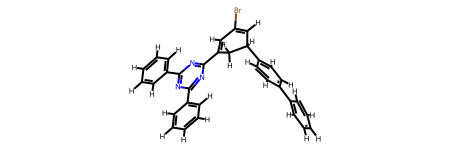

In [4]:
# mol_example = df.rdkit_mol_cistrans_stereo.iloc[6]# 0
mol_example = smiles_to_3d_mol(
    df.ID.iloc[0],
    max_number_of_attempts=100,
    max_number_of_atoms=100
)
display(mol_example)

In [17]:
data = get_chiro_data_from_mol(mol_example)
data = vertex_graph_transform(
    data,
    mol=mol_example,
    transformation_mode="permutation_tree",
    transformation_parameters={'k': 3}
)
display(data)

Data(x=[61, 52], edge_index=[2, 132], edge_attr=[132, 14], pos=[61, 3], bond_distances=[66], bond_distance_index=[2, 66], bond_angles=[108], bond_angle_index=[3, 108], dihedral_angles=[163], dihedral_angle_index=[4, 163], ptree=[61], initial_map=[209], layer0_order_matrix=[1], layer0_type_mask=[1], layer0_pooling=[1], num_layer=3, layer1_order_matrix=[1], layer1_type_mask=[1], layer1_pooling=[1], layer2_order_matrix=[1], layer2_type_mask=[1], layer2_pooling=[1])

## Plan:
- ring gets extra node with tree (c or z) connecting members of ring
- interconnect such nodes which share nodes? include in c/z at position? (probably not a good idea) or use separate c/z to display surrounding cycles
- include extra nodes in tree of participating nodes (extra position 4 in S ?)
- or: remove edges between nodes of cycle, i.e. tree modification, may be bad for chirality

In [18]:
# getting rings
atom_rings = list(mol_example.GetRingInfo().AtomRings())
atom_rings

[(1, 36, 17, 16, 3, 2),
 (5, 6, 7, 14, 15, 4),
 (9, 10, 11, 12, 13, 8),
 (19, 20, 27, 28, 35, 18),
 (22, 23, 24, 25, 26, 21),
 (30, 31, 32, 33, 34, 29)]

In [19]:
offset = data.x.shape[0]

In [22]:
for idx, ring in enumerate(atom_rings):

    # prepare tree
    # todo: adapt to edge graph
    ptree_ring = {
        "C": [
            list(ring)
        ]
    }

    # add node
    data.x = torch.cat([
        data.x,
        torch.zeros(1, data.x.shape[1])
    ], dim=0)

    ptree_neighbor_rings = []

    # check with connection to other trees
    for o_idx, other_rings in enumerate(atom_rings):
        if idx == o_idx:
            continue

        # check if connected
        intersection = list(set(ring) & set(other_rings))

        if len(intersection):
            ptree_neighbor_rings.append(offset + o_idx)

    if len(ptree_neighbor_rings):
        data.ptree.append(json.dumps({
            "S": [
                ptree_ring,
                {
                    "P": ptree_neighbor_rings
                }
            ]
        }))
    else:
        data.ptree.append(json.dumps(ptree_ring))

In [25]:
for i in range(offset):

    temp_tree = json.loads(data.ptree[i])
    # todo: adapt for edge graph
    if "S" in temp_tree:
        # get rings it is in
        in_rings = [
            offset + idx
            for idx, r in enumerate(atom_rings)
            if i in r
        ]

        if len(in_rings):
            temp_tree["S"].append({
                "P": in_rings
            })
    data.ptree[i] = json.dumps(temp_tree)

In [26]:
display(data, data.ptree)

Data(x=[69, 52], edge_index=[2, 132], edge_attr=[132, 14], pos=[61, 3], bond_distances=[66], bond_distance_index=[2, 66], bond_angles=[108], bond_angle_index=[3, 108], dihedral_angles=[163], dihedral_angle_index=[4, 163], ptree=[69], initial_map=[209], layer0_order_matrix=[1], layer0_type_mask=[1], layer0_pooling=[1], num_layer=3, layer1_order_matrix=[1], layer1_type_mask=[1], layer1_pooling=[1], layer2_order_matrix=[1], layer2_type_mask=[1], layer2_pooling=[1])

['{"S": [0, {"P": [1]}]}',
 '{"S": [1, {"P": [0, 2, 36]}, {"P": [61]}]}',
 '{"S": [2, {"P": [1, 3, 37]}, {"P": [61]}]}',
 '{"S": [3, {"P": [{"Z": [4, 16, 38]}, {"Z": [2, 38, 16]}, {"Z": [2, 4, 38]}, {"Z": [2, 16, 4]}]}, {"P": [61]}]}',
 '{"S": [4, {"P": [3, 5, 15]}, {"P": [62]}]}',
 '{"S": [5, {"P": [4, 6, 39]}, {"P": [62]}]}',
 '{"S": [6, {"P": [5, 7, 40]}, {"P": [62]}]}',
 '{"S": [7, {"P": [6, 8, 14]}, {"P": [62]}]}',
 '{"S": [8, {"P": [7, 9, 13]}, {"P": [63]}]}',
 '{"S": [9, {"P": [8, 10, 41]}, {"P": [63]}]}',
 '{"S": [10, {"P": [9, 11, 42]}, {"P": [63]}]}',
 '{"S": [11, {"P": [10, 12, 43]}, {"P": [63]}]}',
 '{"S": [12, {"P": [11, 13, 44]}, {"P": [63]}]}',
 '{"S": [13, {"P": [8, 12, 45]}, {"P": [63]}]}',
 '{"S": [14, {"P": [7, 15, 46]}, {"P": [62]}]}',
 '{"S": [15, {"P": [4, 14, 47]}, {"P": [62]}]}',
 '{"S": [16, {"P": [{"Z": [17, 48, 49]}, {"Z": [3, 49, 48]}, {"Z": [3, 17, 49]}, {"Z": [3, 48, 17]}]}, {"P": [61]}]}',
 '{"S": [17, {"P": [16, 18, 36]}, {"P": [61]}]}',
 '{"S": [18, {"P

In [23]:
'S' in json.loads(data.ptree[0])

True

In [17]:
data = get_chiro_data_from_mol(mol_example)
data = vertex_graph_transform(
    data,
    mol=mol_example,
    transformation_mode="permutation_tree",
    transformation_parameters={
        'k': 3,
        "add_cyclic_trees": True
    }
)
display(data)

Data(x=[61, 52], edge_index=[2, 132], edge_attr=[132, 14], pos=[61, 3], bond_distances=[66], bond_distance_index=[2, 66], bond_angles=[108], bond_angle_index=[3, 108], dihedral_angles=[163], dihedral_angle_index=[4, 163], ptree=[61], initial_map=[209], layer0_order_matrix=[1], layer0_type_mask=[1], layer0_pooling=[1], num_layer=3, layer1_order_matrix=[1], layer1_type_mask=[1], layer1_pooling=[1], layer2_order_matrix=[1], layer2_type_mask=[1], layer2_pooling=[1])

## Edge graph

In [27]:
df = pd.read_pickle("src/rs/raw/train.pickle")

In [28]:
display(df)

,ID,SMILES_nostereo,rdkit_mol_cistrans_stereo,RS_label,RS_label_binary
0,BrC1=C[C@@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3cc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x0000025B1DB...,S,1
1,BrC1=C[C@@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3cc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x0000025B1DB...,S,1
2,BrC1=C[C@@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3cc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x0000025B1DB...,S,1
3,BrC1=C[C@@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3cc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x0000025B1DB...,S,1
4,BrC1=C[C@@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3cc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x0000025B1DB...,S,1
...,...,...,...,...,...
326860,c1nnc([C@H]2CNCCO2)n1C1CC1,c1nnc(C2CNCCO2)n1C1CC1,<rdkit.Chem.rdchem.Mol object at 0x0000025C0B7...,R,0
326861,c1nnc([C@H]2CNCCO2)n1C1CC1,c1nnc(C2CNCCO2)n1C1CC1,<rdkit.Chem.rdchem.Mol object at 0x0000025C0B7...,R,0
326862,c1nnc([C@H]2CNCCO2)n1C1CC1,c1nnc(C2CNCCO2)n1C1CC1,<rdkit.Chem.rdchem.Mol object at 0x0000025C0B7...,R,0
326863,c1nnc([C@H]2CNCCO2)n1C1CC1,c1nnc(C2CNCCO2)n1C1CC1,<rdkit.Chem.rdchem.Mol object at 0x0000025C0B7...,R,0


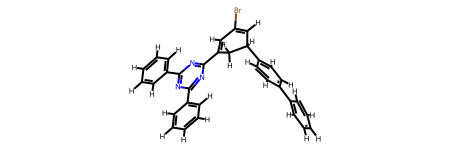

In [29]:
# mol_example = df.rdkit_mol_cistrans_stereo.iloc[6]# 0
mol_example = smiles_to_3d_mol(
    df.ID.iloc[0],
    max_number_of_attempts=100,
    max_number_of_atoms=100
)
display(mol_example)

In [30]:
data = get_chiro_data_from_mol(mol_example)
data = edge_graph_transform(
    data,
    mol=mol_example,
    transformation_mode="permutation_tree",
    transformation_parameters={'k': 3}
)
display(data)

Data(x=[132, 118], edge_index=[2, 348], edge_attr=[348, 80], pos=[132, 6], parallel_node_index=[132], circle_index=[132], ptree=[132], initial_map=[480], layer0_order_matrix=[1], layer0_type_mask=[1], layer0_pooling=[1], num_layer=2, layer1_order_matrix=[1], layer1_type_mask=[1], layer1_pooling=[1])

## Plan:
- ring gets extra node with tree (c or z) connecting members of ring
- interconnect such nodes which share nodes? include in c/z at position? (probably not a good idea) or use separate c/z to display surrounding cycles
- include extra nodes in tree of participating nodes (extra position 4 in S ?)
- or: remove edges between nodes of cycle, i.e. tree modification, may be bad for chirality

In [32]:
# getting rings
atom_rings = list(mol_example.GetRingInfo().AtomRings())
atom_rings

[(1, 36, 17, 16, 3, 2),
 (5, 6, 7, 14, 15, 4),
 (9, 10, 11, 12, 13, 8),
 (19, 20, 27, 28, 35, 18),
 (22, 23, 24, 25, 26, 21),
 (30, 31, 32, 33, 34, 29)]

In [33]:
offset = data.x.shape[0]

In [40]:
list(zip([1,2,3], [1,2,3][1:] + [1,2,3][:1]))

[(1, 2), (2, 3), (3, 1)]

In [22]:
for idx, ring in enumerate(atom_rings):
    # convert ring into edge ring
    edge_ring = list(zip(
        ring,
        ring[1:] + ring[:1]
    ))
    edge_idx_ring_a = [
        node_mapping[(a,b)]
        for a,b in edge_ring
        if (a,b) in node_mapping
    ]
    edge_idx_ring_b = [
        node_mapping[(b,a)]
        for a,b in edge_ring
        if (b,a) in node_mapping
    ]

    # prepare tree
    # todo: adapt to edge graph
    if len(edge_idx_ring_a) and len(edge_idx_ring_b):
        ptree_ring = {
            "P": [{
                "C": [
                    list(edge_idx_ring_a)
                ]
            }, {
                "C": [
                    list(edge_idx_ring_b)
                ]
            }]
        }
    elif len(edge_idx_ring_a):
        ptree_ring = {
            "C": [
                edge_idx_ring_a
            ]
        }
    elif len(edge_idx_ring_b):
        ptree_ring = {
            "C": [
                edge_idx_ring_b
            ]
        }
    else:
        continue

    # add node
    data.x = torch.cat([
        data.x,
        torch.zeros(1, data.x.shape[1])
    ], dim=0)

    ptree_neighbor_rings = []

    # check with connection to other trees
    for o_idx, other_rings in enumerate(atom_rings):
        if idx == o_idx:
            continue

        # check if connected
        intersection = list(set(ring) & set(other_rings))

        if len(intersection):
            ptree_neighbor_rings.append(offset + o_idx)

    if len(ptree_neighbor_rings):
        data.ptree.append(json.dumps({
            "S": [
                ptree_ring,
                {
                    "P": ptree_neighbor_rings
                }
            ]
        }))
    else:
        data.ptree.append(json.dumps(ptree_ring))

In [ ]:
reverse_dict = dict(zip(node_mapping.values(), node_mapping.keys()))

In [25]:
for i in range(offset):
    source, target = reverse_dict[i]

    temp_tree = json.loads(data.ptree[i])
    # todo: adapt for edge graph
    if "S" in temp_tree:
        # get rings it is in
        in_rings = [
            offset + idx
            for idx, r in enumerate(atom_rings)
            if source in r and target in r
        ]

        if len(in_rings):
            temp_tree["S"].append({
                "P": in_rings
            })
    data.ptree[i] = json.dumps(temp_tree)

In [26]:
display(data, data.ptree)

Data(x=[69, 52], edge_index=[2, 132], edge_attr=[132, 14], pos=[61, 3], bond_distances=[66], bond_distance_index=[2, 66], bond_angles=[108], bond_angle_index=[3, 108], dihedral_angles=[163], dihedral_angle_index=[4, 163], ptree=[69], initial_map=[209], layer0_order_matrix=[1], layer0_type_mask=[1], layer0_pooling=[1], num_layer=3, layer1_order_matrix=[1], layer1_type_mask=[1], layer1_pooling=[1], layer2_order_matrix=[1], layer2_type_mask=[1], layer2_pooling=[1])

['{"S": [0, {"P": [1]}]}',
 '{"S": [1, {"P": [0, 2, 36]}, {"P": [61]}]}',
 '{"S": [2, {"P": [1, 3, 37]}, {"P": [61]}]}',
 '{"S": [3, {"P": [{"Z": [4, 16, 38]}, {"Z": [2, 38, 16]}, {"Z": [2, 4, 38]}, {"Z": [2, 16, 4]}]}, {"P": [61]}]}',
 '{"S": [4, {"P": [3, 5, 15]}, {"P": [62]}]}',
 '{"S": [5, {"P": [4, 6, 39]}, {"P": [62]}]}',
 '{"S": [6, {"P": [5, 7, 40]}, {"P": [62]}]}',
 '{"S": [7, {"P": [6, 8, 14]}, {"P": [62]}]}',
 '{"S": [8, {"P": [7, 9, 13]}, {"P": [63]}]}',
 '{"S": [9, {"P": [8, 10, 41]}, {"P": [63]}]}',
 '{"S": [10, {"P": [9, 11, 42]}, {"P": [63]}]}',
 '{"S": [11, {"P": [10, 12, 43]}, {"P": [63]}]}',
 '{"S": [12, {"P": [11, 13, 44]}, {"P": [63]}]}',
 '{"S": [13, {"P": [8, 12, 45]}, {"P": [63]}]}',
 '{"S": [14, {"P": [7, 15, 46]}, {"P": [62]}]}',
 '{"S": [15, {"P": [4, 14, 47]}, {"P": [62]}]}',
 '{"S": [16, {"P": [{"Z": [17, 48, 49]}, {"Z": [3, 49, 48]}, {"Z": [3, 17, 49]}, {"Z": [3, 48, 17]}]}, {"P": [61]}]}',
 '{"S": [17, {"P": [16, 18, 36]}, {"P": [61]}]}',
 '{"S": [18, {"P

In [23]:
'S' in json.loads(data.ptree[0])

True

In [30]:
data = get_chiro_data_from_mol(mol_example)
data = edge_graph_transform(
    data,
    mol=mol_example,
    transformation_mode="permutation_tree",
    transformation_parameters={'k': 3}
)
display(data)

Data(x=[132, 118], edge_index=[2, 348], edge_attr=[348, 80], pos=[132, 6], parallel_node_index=[132], circle_index=[132], ptree=[132], initial_map=[480], layer0_order_matrix=[1], layer0_type_mask=[1], layer0_pooling=[1], num_layer=2, layer1_order_matrix=[1], layer1_type_mask=[1], layer1_pooling=[1])